In [38]:
#Package import 
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms 
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
import matplotlib.pyplot as plt 
import seaborn as sns
from math import ceil

%matplotlib inline

In [4]:
df = pd.read_csv('ab_data.csv')

In [9]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,294478.0,787974.124733,91210.823776,630000.0,709032.25,787933.5,866911.75,945999.0
converted,294478.0,0.119659,0.324563,0.0,0.00,0.0,0.00,1.0


In [15]:
#Calculating effect size based on our expected rates
effect_size = sms.proportion_effectsize(0.13, 0.15) 
#Calculatin sample size needed
required_n = sms.NormalIndPower().solve_power(
    effect_size,
    power = 0.8,
    alpha = 0.05,
    ratio = 1
)

In [23]:
required_n = np.round(required_n).astype(int)
print(required_n)

4719


In [17]:
pd.crosstab(df['group'],df['landing_page'])

landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


In [18]:
session_counts = df['user_id'].value_counts(ascending = False)
multi_user = session_counts[session_counts > 1].count()

In [19]:
print(f'There are {multi_user} people using the session more than 1 time')

There are 3894 people using the session more than 1 time


In [21]:
drop_multi_user = session_counts[session_counts > 1].index

df = df[~df['user_id'].isin(drop_multi_user)]

In [24]:
control_sample = df[df['group'] == 'control'].sample(n = required_n, random_state= 42)
treatment_sample = df[df['group'] == 'treatment'].sample(n= required_n, random_state = 42)


In [25]:
ab_test = pd.concat([control_sample, treatment_sample], axis = 0)
ab_test.reset_index(drop= True,inplace = True)
ab_test

,user_id,timestamp,group,landing_page,converted
0,663037,2017-01-05 02:13:38.063443,control,old_page,0
1,932826,2017-01-13 04:50:06.941679,control,old_page,1
2,922999,2017-01-04 07:19:23.813317,control,old_page,0
3,857826,2017-01-19 02:27:37.678241,control,old_page,0
4,762926,2017-01-18 17:50:59.261406,control,old_page,0
...,...,...,...,...,...
9433,632014,2017-01-02 20:23:42.898402,treatment,new_page,0
9434,649363,2017-01-13 00:10:17.571044,treatment,new_page,0
9435,868879,2017-01-06 12:21:41.396652,treatment,new_page,0
9436,792022,2017-01-24 03:55:24.551307,treatment,new_page,0


In [27]:
ab_test['group'].value_counts()

group
control      4719
treatment    4719
Name: count, dtype: int64

In [32]:
conversion_rates = ab_test.groupby('group')['converted']
#Calculate Standar deviation of the proportion
std_p = lambda x: np.std(x ,ddof =0)

#Standard error of the proportion
se_p = lambda x: stats.sem(x, ddof=0)

In [33]:
conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate','std_deviation','std_error']

conversion_rates

/var/folders/b7/cpy_k2_d7ync67bk0d9sd_qr0000gn/T/ipykernel_31164/3182488868.py:1: FutureWarning: The provided callable <function mean at 0x109176a60> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])


,conversion_rate,std_deviation,std_error
group,,,
control,0.115491,0.319613,0.004653
treatment,0.129053,0.335258,0.004880


/var/folders/b7/cpy_k2_d7ync67bk0d9sd_qr0000gn/T/ipykernel_31164/2207604887.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  sns.barplot(x=ab_test['group'], y=ab_test['converted'], ci=False, hue = ab_test['group'])


Text(0, 0.5, 'Converted(Proportion)')

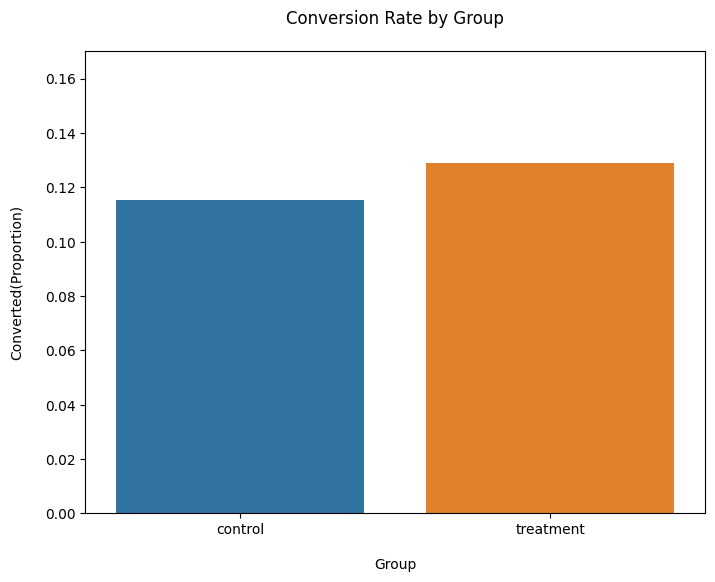

In [36]:
plt.figure(figsize = (8,6))

sns.barplot(x=ab_test['group'], y=ab_test['converted'], ci=False, hue = ab_test['group'])
plt.ylim(0, 0.17)
plt.title('Conversion Rate by Group', pad = 20)
plt.xlabel('Group',labelpad = 15)
plt.ylabel('Converted(Proportion)', labelpad=15)

In [47]:
control_result = ab_test[ab_test['group'] == 'control']['converted']
treatment_result = ab_test[ab_test['group'] == 'treatment']['converted']

number_control = control_result.sum()
number_treatment = treatment_result.sum()
success = [control_result.sum(), treatment_result.sum()]
number_observation = [number_control,number_treatment]


In [46]:
success

[np.int64(545), np.int64(609)]

In [48]:
z_stat, pval = proportions_ztest(success, nobs = number_observation)
# Calculate confidence intervals for proportions
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(success, nobs= number_observation, alpha=0.05)
print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: nan
p-value: nan
ci 95% for control group: [1.000, 1.000]
ci 95% for treatment group: [1.000, 1.000]


/Users/alextran/Library/Python/3.9/lib/python/site-packages/statsmodels/stats/weightstats.py:792: RuntimeWarning: invalid value encountered in scalar divide
  zstat = value / std


In [44]:
print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: nan
p-value: nan
ci 95% for control group: [1.000, 1.000]
ci 95% for treatment group: [1.000, 1.000]
